# 学習済みのInceptionV3を使って画像に写っているメンバーを検出する

例に使う画像は下記のURLから引用したこちらの画像  
URL http://www.keyakizaka46.com/s/k46o/diary/detail/16595?ima=0000&cd=member

In [1]:
test_image_filepath = 'test/test_image.jpg'

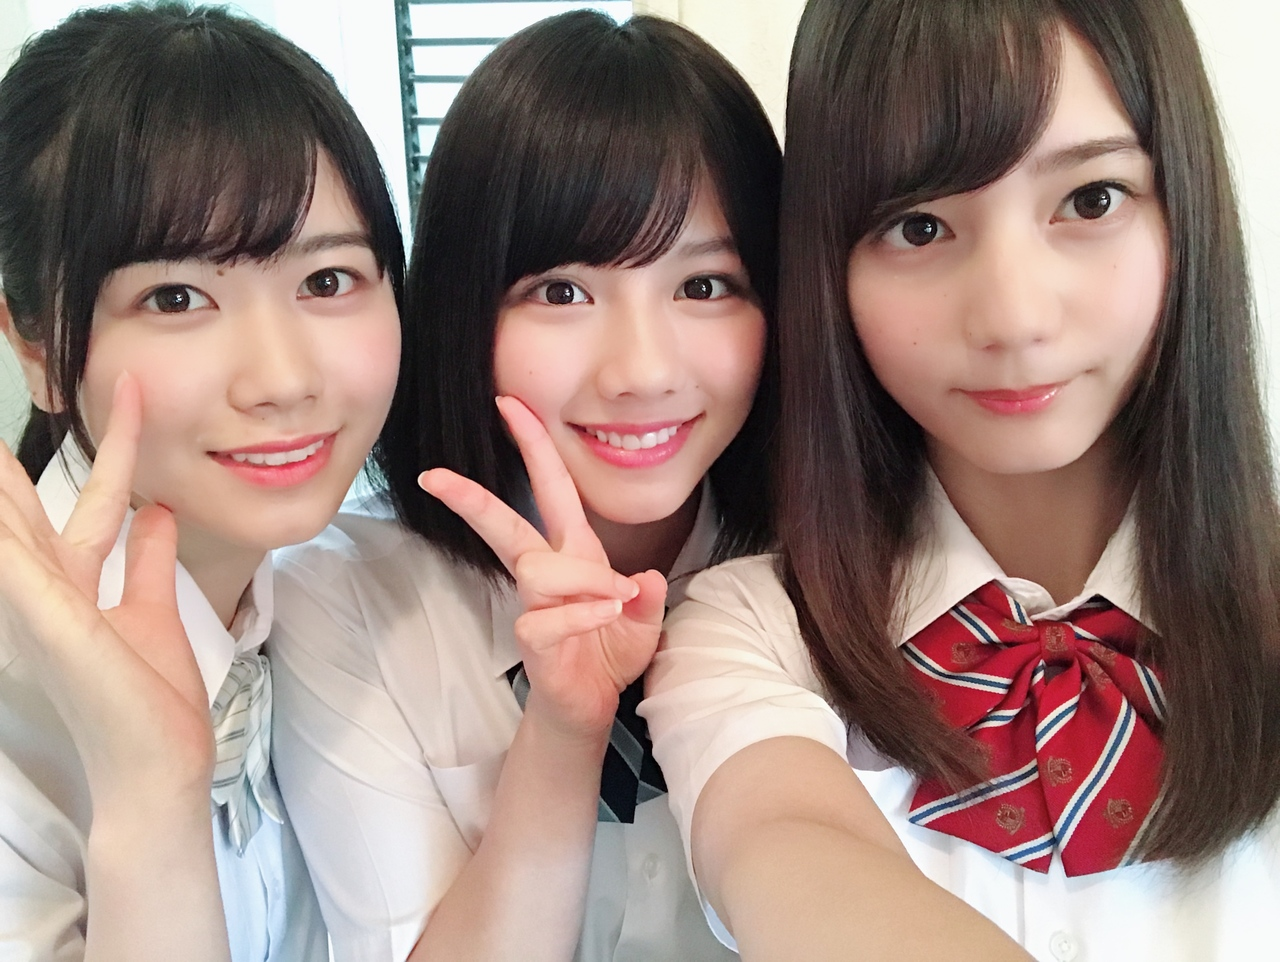

In [2]:
from IPython.display import display_jpeg, Image
display_jpeg(Image('test/test_image.jpg'))

左から 丹生明里、渡邉美穂、小坂菜緒

# 画像から顔を抜き出す
まずは画像から3人の顔をopenCVで抜き出す。

In [3]:
import cv2
import numpy as np


def extract_faces_from_image(path,size=(224, 224)):
    image = cv2.imread(path)
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    FACE_CASCADE_PATH = ('/home/ishiyama/tensorflow/lib/python3.5/'
                         'site-packages/cv2/data/haarcascade_frontalface_default.xml')
    face_cascade = cv2.CascadeClassifier(FACE_CASCADE_PATH)
    face_cordinates = face_cascade.detectMultiScale(image_gray, 1.1, 5)
    faces = []
    for (left, top, width, height) in face_cordinates:
        bottom = top + height
        right = left + width
        face = image[top:bottom, left:right]
        faces.append(cv2.resize(face, size))
    return np.array(faces)

# 抜き出した画像をそれぞれメンバー識別器にかけて誰が写っているのかを特定する

In [8]:
import csv
import keras
import pandas as pd


class KeyakizakaMemberRecognizer(object):
    def __init__(self):
        self.load_model()
        self.load_member_master()

    def load_model(self):
        self.model = keras.models.load_model('keyakizaka_member_detection_inceptionv3.h5')
    
    def load_member_master(self):
        with open('member_list.csv', 'r') as f:
            reader = csv.DictReader(f)
            _member_master = {x['member_id']: x['member_name'] for x in reader}
        self.member_master = _member_master

    def __call__(self, images):
        predicted = self.model.predict(images)
        estimated_probability = predicted.max(axis=1)
        estimated_member_id = predicted.argmax(axis=1)

        estimated_member = []
        for member_id, prob in zip(estimated_member_id, estimated_probability):
            _member_id = str(member_id)
            _member = {
                'member_id': _member_id,
                'member_name': self.member_master[_member_id],
                'probability': '{:.5f}'.format(prob)
            }
            estimated_member.append(_member)
        return estimated_member

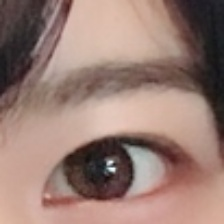

[{'member_id': '33', 'probability': '0.91119', 'member_name': '金村美玖'}]


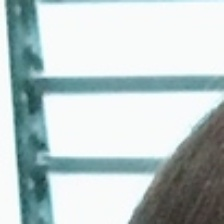

[{'member_id': '24', 'probability': '0.98425', 'member_name': '影山優佳'}]


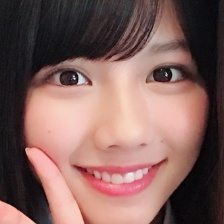

[{'member_id': '26', 'probability': '0.74381', 'member_name': '齊藤京子'}]


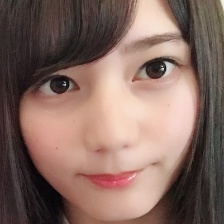

[{'member_id': '26', 'probability': '0.98069', 'member_name': '齊藤京子'}]


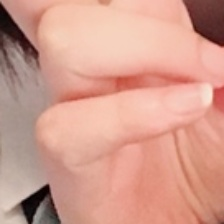

[{'member_id': '6', 'probability': '0.94500', 'member_name': '小池美波'}]


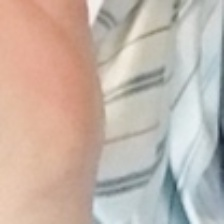

[{'member_id': '35', 'probability': '0.94127', 'member_name': '小坂菜緒'}]


In [9]:
faces = extract_faces_from_image(path='test/test_image.jpg')
recognize_keyakizaka_member = KeyakizakaMemberRecognizer()
for i, face in enumerate(faces, start=1):
    save_path = str('test/face{:02d}.jpg'.format(i))
    cv2.imwrite(save_path, face)
    display_jpeg(Image(save_path))
    result = recognize_keyakizaka_member(face.reshape(1, *face.shape))
    print(result)

誰も当たってないし...orz